# CPSC 368 Impact By Disease (KNM Neighbours)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display

In [2]:
USCDI = pd.read_csv('final_datasets_V1/cleaned/U.S._Chronic_Disease_Indicators_newcols.csv')
KFF2019_new = pd.read_csv("final_datasets_V1/cleaned/KFF2019_new.csv")

In [3]:
print("DataFrame shape:", USCDI.shape)

DataFrame shape: (309215, 13)


After reading the data file, we see that it contains 309,215 observations and 13 attributes. Further analysis, including checking for missing values, will be conducted later, as filtering needs to be applied to finalize the dataset.

In [4]:
USCDI['DataValueUnit'] = USCDI['DataValueUnit'].replace({'cases per 100,000': 'per 100,000'})

In [5]:
USCDI_filter1 = USCDI[
    (USCDI['LocationDesc'].isin(['Texas', 'Massachusetts'])) &
    (USCDI['Topic'].isin(['Cardiovascular Disease', 'Cancer'])) &
    (USCDI['DataValueUnit'] == "per 100,000")&
    (USCDI['DataValueType'] == "Crude Rate") &
    (USCDI["Has2019"] == True)
]

In [6]:
USCDI_filter2 = USCDI_filter1[['Stratification1','Question','LocationDesc', 'Topic', 'DataValueUnit','DataValueType', 'AvgDataValue']]
USCDI_final = pd.merge(USCDI_filter2, KFF2019_new[['Location', 'All_Uninsured']], 
                     left_on='LocationDesc', right_on='Location', how='left')
USCDI_final.drop(columns='Location', inplace=True)
USCDI_final.rename(columns={'AvgDataValue': 'AvgDeathRate'}, inplace=True)
USCDI_final.rename(columns={'DataValueType': 'DeathRateType'}, inplace=True)
USCDI_final.rename(columns={'DataValueUnit': 'DeathRateUnit'}, inplace=True)
USCDI_final.rename(columns={'Topic': 'Disease'}, inplace = True)
USCDI_final.rename(columns={'LocationDesc': 'State'}, inplace = True)

In [7]:
USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Cervical cancer mortality among all females, underlying cause': 
     'Cervical cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Invasive cancer (all sites combined) mortality among all people, underlying cause': 
     'Invasive cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Breast cancer mortality among all females, underlying cause': 
     'Breast cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Colon and rectum (colorectal) cancer mortality among all people, underlying cause': 
     'Colorectal cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Lung and bronchial cancer mortality among all people, underlying cause': 
     'Lung cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Prostate cancer mortality among all males, underlying cause': 
     'Prostate cancer'})

USCDI_final['Question'] = USCDI_final['Question'].replace(
    {'Coronary heart disease mortality among all people, underlying cause': 
     'Coronary heart disease'})

USCDI_final = USCDI_final[USCDI_final['Question'].isin(['Cervical cancer', 'Breast cancer',
                                                        'Colorectal cancer', 'Prostate cancer',
                                                       'Lung cancer', 'Coronary heart disease'])]

USCDI_final.rename(columns={'Question': 'Type'}, inplace=True)

We selected the necessary attributes and renamed some for clarity. Note that we excluded invasive cancer because it is too broad—it includes many different types of "invasive" cancer, making it unsuitable for analyzing the impact of specific cancer types.

In [8]:
USCDI_final.isnull().sum()

Stratification1    0
Type               0
State              0
Disease            0
DeathRateUnit      0
DeathRateType      0
AvgDeathRate       0
All_Uninsured      0
dtype: int64

The attributes needed from the final dataset does not contain missing values, therefore imputation is unnecessary.

In [9]:
CHD = USCDI_final[
    (USCDI_final['Disease'] == "Cardiovascular Disease")]

CANCER = USCDI_final[USCDI_final['Disease'] == "Cancer"]

Since we are examining coronary heart disease and cancer, the dataset is divided into two subsets.

In [10]:
Q1 = CHD["AvgDeathRate"].quantile(0.25)  
Q3 = CHD["AvgDeathRate"].quantile(0.75) 
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_CHD = CHD[(CHD["AvgDeathRate"] < lower_bound) | (CHD["AvgDeathRate"] > upper_bound)]
display(outliers_CHD)

,Stratification1,Type,State,Disease,DeathRateUnit,DeathRateType,AvgDeathRate,All_Uninsured
234,Age >=65,Coronary heart disease,Massachusetts,Cardiovascular Disease,"per 100,000",Crude Rate,411.2,0.044
300,Age >=65,Coronary heart disease,Texas,Cardiovascular Disease,"per 100,000",Crude Rate,518.1,0.245


In [11]:
CHD = CHD[(CHD["AvgDeathRate"] >= lower_bound) & (CHD["AvgDeathRate"] <= upper_bound)]

In [12]:
CHD.groupby(["State"])["AvgDeathRate"].agg(["mean","std","min","max","count"])

,mean,std,min,max,count
State,,,,,
Massachusetts,42.800,39.094454,0.0,105.8,12
Texas,58.725,43.869789,0.0,138.3,12


Potential outliers were identified and removed using a statistical method for the CHD dataset. Two outliers were detected and removed.

After removing the outliers, a summary table with descriptive statistics is provided for both states.

Regarding CHD, Texas has a higher death rate than Massachusetts.

In [13]:
Q1 = CANCER["AvgDeathRate"].quantile(0.25)  
Q3 = CANCER["AvgDeathRate"].quantile(0.75) 
IQR = Q3 - Q1  

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_CANCER = CANCER[(CANCER["AvgDeathRate"] < lower_bound) | (CANCER["AvgDeathRate"] > upper_bound)]
display(outliers_CANCER)

,Stratification1,Type,State,Disease,DeathRateUnit,DeathRateType,AvgDeathRate,All_Uninsured
22,"White, non-Hispanic",Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,10.72,0.044
42,"White, non-Hispanic",Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,11.02,0.044
47,Male,Lung cancer,Massachusetts,Cancer,"per 100,000",Crude Rate,9.12,0.044
164,"White, non-Hispanic",Lung cancer,Texas,Cancer,"per 100,000",Crude Rate,10.94,0.245
200,"White, non-Hispanic",Lung cancer,Texas,Cancer,"per 100,000",Crude Rate,10.76,0.245


In [14]:
CANCER = CANCER[(CANCER["AvgDeathRate"] >= lower_bound) & (CANCER["AvgDeathRate"] <= upper_bound)]

In [15]:
CANCER.groupby(["State","Type"])["AvgDeathRate"].agg(["mean","std","min","max","count"])

mean       std   min   max  count
State         Type                                                    
Massachusetts Breast cancer      2.677500  2.061079  0.00  5.32     16
              Cervical cancer    0.216250  0.135690  0.00  0.40     16
              Colorectal cancer  1.968750  1.159355  0.00  3.36     16
              Lung cancer        5.132308  3.252307  0.00  9.00     13
              Prostate cancer    2.278750  1.886534  0.00  4.54     16
Texas         Breast cancer      3.212500  1.984270  0.00  5.88     16
              Cervical cancer    0.415000  0.272127  0.00  0.72     16
              Colorectal cancer  2.423750  0.931757  1.04  3.80     16
              Lung cancer        4.640000  2.053979  1.82  7.18     14
              Prostate cancer    1.931250  1.607598  0.00  4.20     16

Similarly, potential outliers in the cancer dataset were identified and removed using a statistical method. Five outliers were detected and removed. After removing the outliers, a summary table with descriptive statistics is provided for both states. The summary table shows that lung cancer has the highest mean death rate, while cervical cancer has the lowest. Overall, Texas has a higher mean death rate for three out of five cancers, while lung and prostate cancer death rates are higher in Massachusetts.

## Visualizations

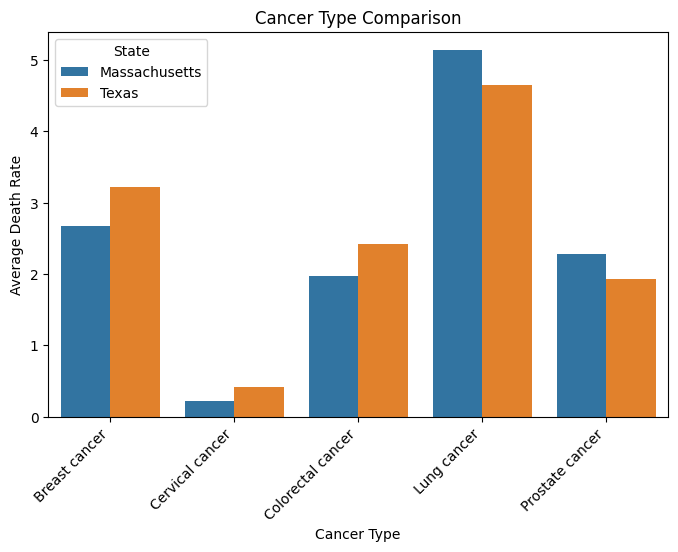

In [16]:
eda_summary_cancer = CANCER.groupby(['State', 'Type'])['AvgDeathRate'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=eda_summary_cancer, x='Type', y='AvgDeathRate', hue='State')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Cancer Type')
plt.ylabel('Average Death Rate')
plt.title('Cancer Type Comparison')
plt.legend(title='State')
plt.show()

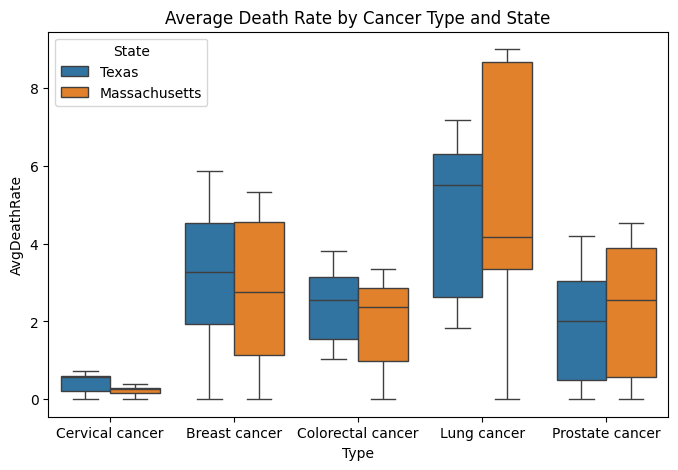

In [17]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=CANCER, x='Type', y='AvgDeathRate', hue='State')
plt.title("Average Death Rate by Cancer Type and State")
plt.show()

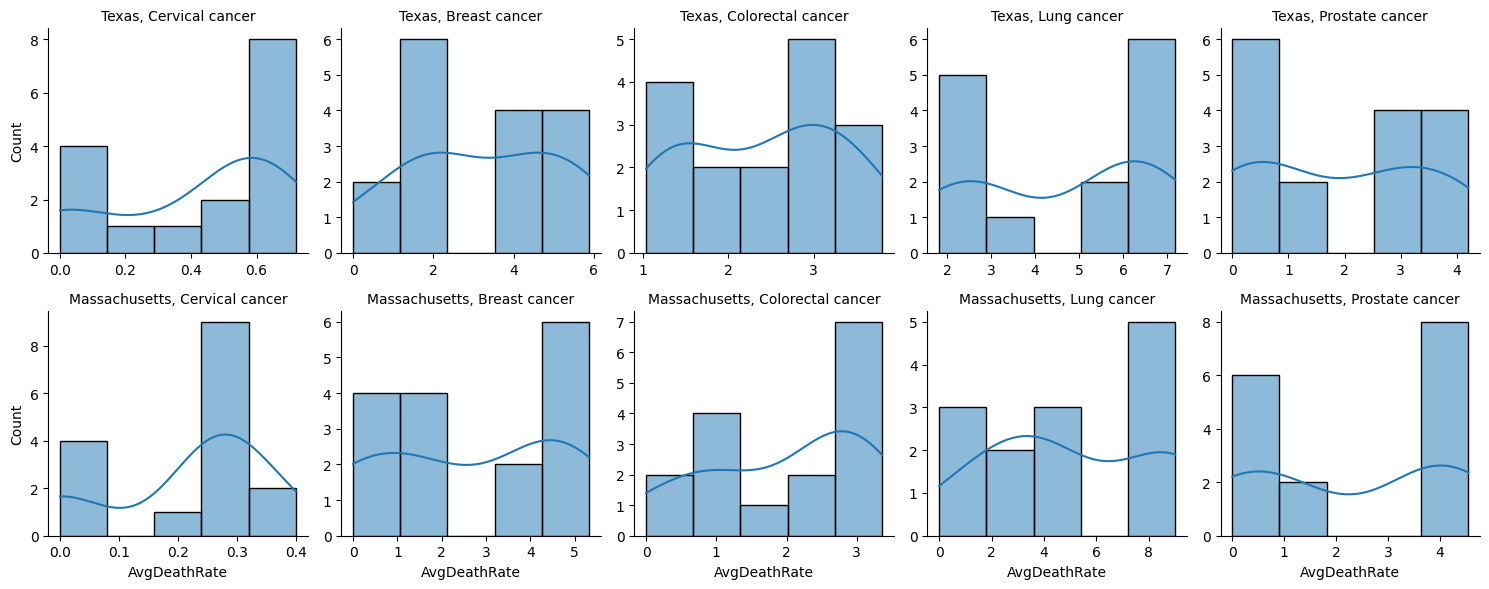

In [18]:
g = sns.FacetGrid(data= CANCER, row = "State", col="Type", height=3, sharex=False, sharey=False)
g.map(sns.histplot, "AvgDeathRate", kde=True)

g.set_titles("{row_name}, {col_name}")
g.set_axis_labels("AvgDeathRate", "Count")
plt.tight_layout()
plt.show()

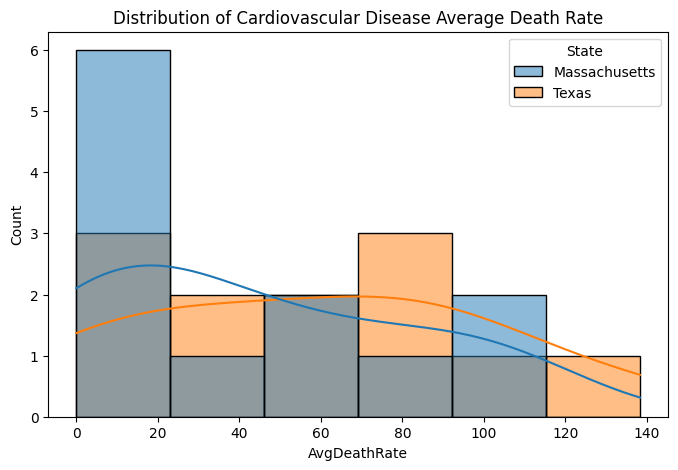

In [19]:
plt.figure(figsize=(8, 5))
sns.histplot(data= CHD, x='AvgDeathRate', hue='State', kde=True)
plt.title("Distribution of Cardiovascular Disease Average Death Rate")
plt.show()

The visualizations further confirm the findings from the summary table. This result is expected, as Texas has a higher uninsured rate compared to Massachusetts. This suggests that insurance coverage may play a significant role in reducing death rates for the diseases and cancer types analyzed.